## Event Analysis Notebook

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
from tabulate import tabulate
import networkx as nx
import analysis_functions
import random
import math
import numpy as np

In [37]:
### Load Data 
voteData = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\votes.csv')
groupData = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\users_to_groups.csv')
forumQuestions = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\forum_questions.csv')
groupCategories = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\group_categories.csv')
questionOptions = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\question_options.csv')

# print("voteData:", len(voteData))
# print("groupData:", len(groupData))
# print("forumQuestions:", len(forumQuestions))
# print("groupCategories:", len(groupCategories))

### Manual Analysis

In [38]:
# Specify group categories to be considered for the analysis (at least 'affiliation' must be specified)
group_categories = ['affiliation', 'private']

# Specify an option id
option_id = '4ad65252-e651-460c-af6b-289769a3964b'

In [39]:
# Analysis of a given option id 
votes = analysis_functions.get_latest_vote_by_user_and_optionid(voteData, option_id)
filtered_votes = analysis_functions.filter_zero_votes(votes)
group_categories_ids = analysis_functions.get_group_categories_ids(groupCategories, group_categories)
groups = analysis_functions.get_groups_by_user_and_optionid(groupData, filtered_votes, group_categories_ids)
memberships = analysis_functions.create_group_memberships(groups)
filtered_groups = analysis_functions.remove_duplicate_groups(groups)
plurality_score = analysis_functions.connection_oriented_cluster_match(filtered_groups, filtered_votes)

# print("votes:", votes)
# print("filtered_votes:", filtered_votes)
# print("group_categories_ids:", group_categories_ids)
# print("groups:", groups)
# print("memberships:", memberships)
# print("filtered_groups:", filtered_groups)
# print("plurality_score:", plurality_score)

### Voting Results Table  

In [40]:
# specify a question id 
question_id = '5eaea820-8b02-446c-bf17-59f6fc1799bc'

# Specify group categories to be considered for the analysis (at least 'affiliation' must be specified)
group_categories = ['affiliation', 'private']

# get list of option ids related to the question id 
optionIds = questionOptions[questionOptions['question_id'] == question_id]['id'].tolist()

In [41]:
# Generate Results 
results_dict = analysis_functions.get_results_dict(optionIds, voteData, groupData, groupCategories, group_categories)

# add a rank to each result category (plural score, raw votes, quadratic score)
results_dict_with_ranks = analysis_functions.calculate_ranks(results_dict)

# Sort results according to the plurality score
sorted_results_dict_with_ranks = dict(sorted(results_dict_with_ranks.items(), key=lambda item: item[1]['pluralityScore']['score'], reverse=True))

In [42]:
# Create data table 
table_data = []
headers = ['Options', 'Plurality Score', 'Quadratic Score', 'Raw Votes']

option_counter = 1

for option, data in sorted_results_dict_with_ranks.items():
    row = [f'Option {option_counter}']
    for category in ['pluralityScore', 'quadraticScore', 'totalRawVotes']:
        row.append(round(data[category]['score'], 3))
    table_data.append(row)
    option_counter += 1 

df = pd.DataFrame(table_data, columns=headers)

In [43]:
# Save and Print results 
df.to_excel('plots-and-tables/voting_results.xlsx', index=False)
print(tabulate(df, headers='keys', tablefmt='pretty'))

+----+-----------+-----------------+-----------------+-----------+
|    |  Options  | Plurality Score | Quadratic Score | Raw Votes |
+----+-----------+-----------------+-----------------+-----------+
| 0  | Option 1  |      59.45      |     64.658      |    213    |
| 1  | Option 2  |     42.394      |     43.858      |    196    |
| 2  | Option 3  |     39.655      |     50.425      |    263    |
| 3  | Option 4  |     38.545      |     41.391      |    124    |
| 4  | Option 5  |     36.083      |     37.335      |    124    |
| 5  | Option 6  |     36.031      |     37.566      |    110    |
| 6  | Option 7  |     32.766      |     31.035      |    82     |
| 7  | Option 8  |      30.99      |     32.565      |    86     |
| 8  | Option 9  |     27.541      |     28.423      |    60     |
| 9  | Option 10 |     27.254      |     28.397      |    82     |
| 10 | Option 11 |     25.808      |     25.104      |    64     |
| 11 | Option 12 |     25.604      |      26.75      |    67  

### Result Visualizations

#### Ranking Distribution

In [44]:
# Define the categories and custom labels for the x-axis
categories = ['pluralityScore', 'quadraticScore', 'totalRawVotes']
custom_labels = ['Plurality Score Rank', 'Quadratic Score Rank', 'Raw Votes Rank']

# Get the number of options
num_options = len(sorted_results_dict_with_ranks)

# Get a list of distinct colors
colors = list(TABLEAU_COLORS.values())

# Ensure enough colors for all options, if not, repeat the colors
while len(colors) < num_options:
    colors.extend(colors)

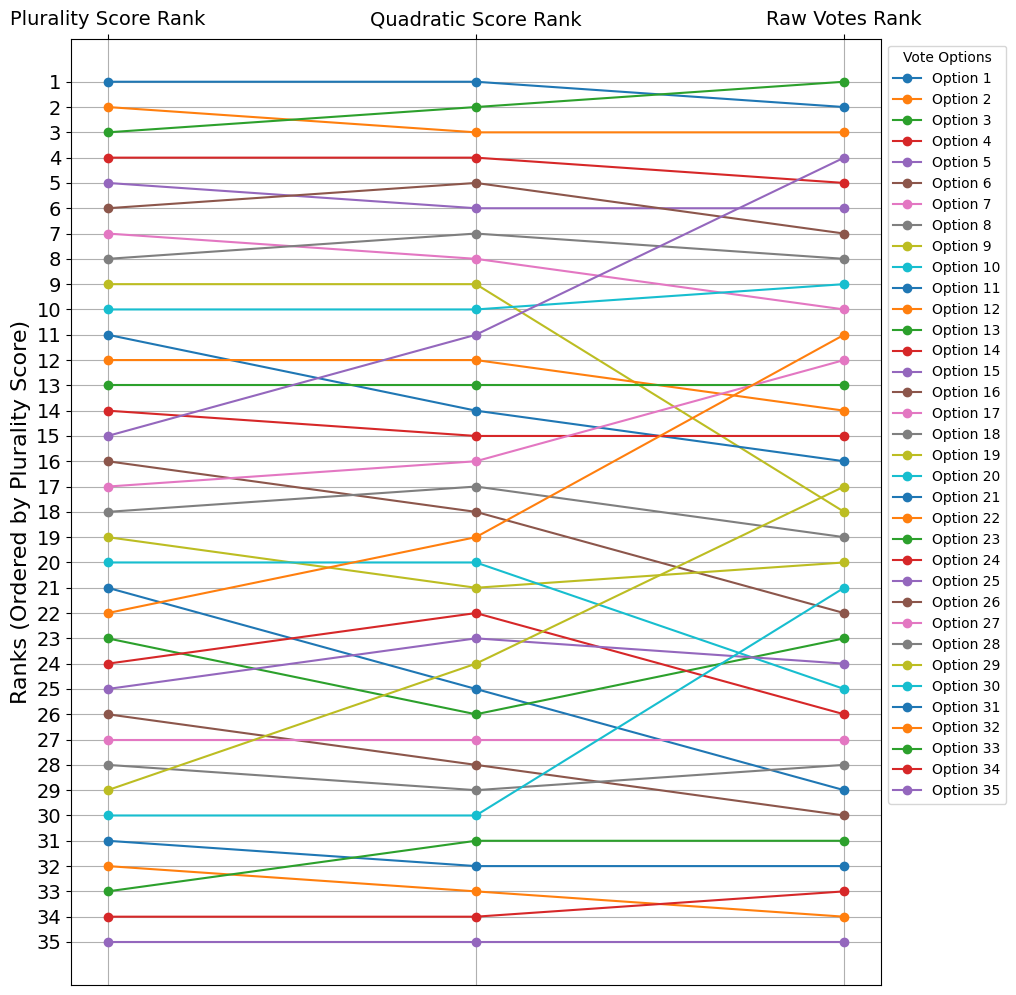

In [45]:
# Bump Chart 
plt.figure(figsize=(10, 10))

for i, (option, option_data) in enumerate(sorted_results_dict_with_ranks.items()):
    ranks = [option_data[category]['rank'] for category in categories]
    plt.plot(categories, ranks, marker='o', label=f'Option {i+1}', color=colors[i])

plt.gca().invert_yaxis() 
plt.yticks(range(1, max(ranks) + 1))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Vote Options')
plt.grid(True)
plt.gca().xaxis.tick_top()
plt.gca().set_xticks(range(len(categories)))
plt.gca().set_xticklabels(custom_labels)
plt.tight_layout()
plt.gca().tick_params(axis='y', labelsize=14)
plt.gca().tick_params(axis='x', labelsize=14)
plt.xlabel('', fontsize=16)
plt.ylabel('Ranks (Ordered by Plurality Score)', fontsize=16)
plt.title('', fontsize=16)

# Save the plot as a PNG file
plt.savefig('plots-and-tables/bump_chart.png')

#### Highlighted Ranking Distribution

In [46]:
# Calculate the absolute difference in ranks for each ranking category
rank_diff = {}
for option, option_data in sorted_results_dict_with_ranks.items():
    ranks = [option_data[category]['rank'] for category in categories]
    diff = max(ranks) - min(ranks)
    rank_diff[option] = diff

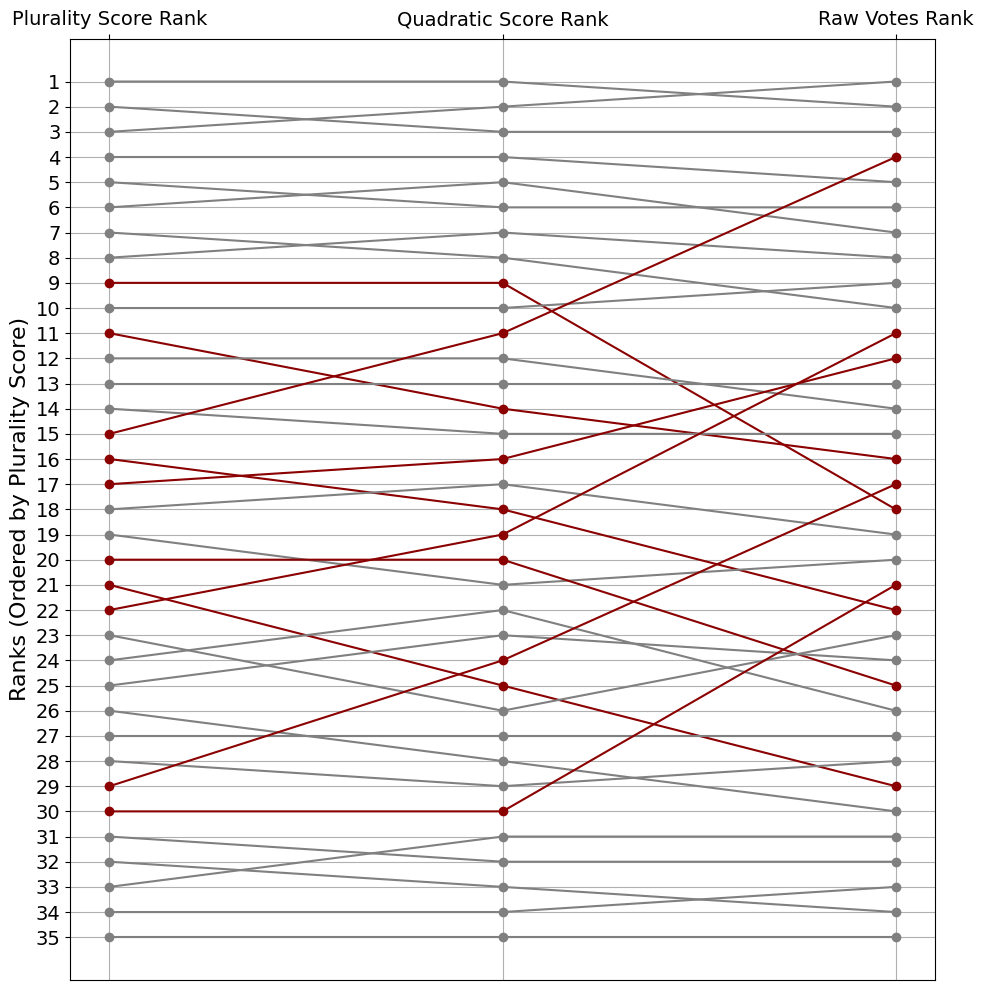

In [47]:
# Bump chart highlighting large differences in the ranking distribution
plt.figure(figsize=(10, 10))

for i, (option, option_data) in enumerate(sorted_results_dict_with_ranks.items()):
    ranks = [option_data[category]['rank'] for category in categories]
    if rank_diff[option] > 4:
        color = 'darkred'
    else:
        color = 'gray'
    plt.plot(categories, ranks, marker='o', label=f'Option {i+1}', color=color)

plt.gca().invert_yaxis()
plt.yticks(range(1, max(ranks) + 1))
plt.gca().tick_params(axis='y', labelsize=14)
plt.gca().tick_params(axis='x', labelsize=14)
plt.xlabel('', fontsize=16)
plt.ylabel('Ranks (Ordered by Plurality Score)', fontsize=16)
plt.title('', fontsize=16)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Vote Options')  # Include legend title
plt.grid(True)
plt.gca().xaxis.tick_top()
plt.gca().set_xticks(range(len(categories)))
plt.gca().set_xticklabels(custom_labels, fontsize=14)
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('plots-and-tables/bump_chart_without_legend.png')

### Network Visualization

In [48]:
# filter group data by users who voted and by relevant group categories 
distinct_user_ids = voteData['user_id'].unique().tolist()
filtered_group_users = groupData[groupData['user_id'].isin(distinct_user_ids)]
group_categories_ids = analysis_functions.get_group_categories_ids(groupCategories, names=['affiliation', 'private'])
filtered_group_users_categories = filtered_group_users[filtered_group_users['group_category_id'].isin(group_categories_ids)]

print("Number of unique users:", filtered_group_users['user_id'].nunique())
print("Number of group categories:", filtered_group_users_categories['group_category_id'].nunique())
print("Length of group data:", len(filtered_group_users_categories))

Number of unique users: 36
Number of group categories: 2
Length of group data: 60


In [49]:
# Group by 'user_id' and aggregate 'group_id' and 'group_category_id' into lists
reduced_filtered_group_users_categories = filtered_group_users_categories.groupby('user_id').agg({'group_id': list, 'group_category_id': list}).reset_index()
# reduced_filtered_group_users_categories.head()

In [50]:
# Get Network Nodes
all_user_ids = set(filtered_group_users_categories['user_id'])
node_list = [{'id': user_id} for user_id in all_user_ids]

# Get Network Edges
edge_list = []

grouped = filtered_group_users_categories.groupby('group_id')
for group_id, group_data in grouped:
    # Create pairs of users within the group
    for i in range(len(group_data)):
        for j in range(i + 1, len(group_data)):
            edge_list.append({'source': group_data.iloc[i]['user_id'], 'target': group_data.iloc[j]['user_id']})

edge_df = pd.DataFrame(edge_list)

In [51]:
# Create edge attribute highlighting the affiliation relationship between nodes 
 
merged_df = pd.merge(edge_df, reduced_filtered_group_users_categories, left_on='source', right_on='user_id', suffixes=('', '_source'))
merged_df = pd.merge(merged_df, reduced_filtered_group_users_categories, left_on='target', right_on='user_id', suffixes=('', '_target'))

# Define function to find common groups and group categories
def find_shared_groups_and_categories(row):
    source_groups = set(row['group_id'])
    target_groups = set(row['group_id_target'])
    shared_groups = source_groups.intersection(target_groups)
    
    shared_group_categories = []
    for group in shared_groups:
        source_category = row['group_category_id'][row['group_id'].index(group)]
        target_category = row['group_category_id_target'][row['group_id_target'].index(group)]
        if source_category == target_category:
            shared_group_categories.append(source_category)
        else:
            shared_group_categories.extend([source_category, target_category])
    
    return pd.Series([list(shared_groups), list(set(shared_group_categories))])

# Apply the function to each row and create new columns 'shared_groups' and 'shared_group_categories'
merged_df[['shared_groups', 'shared_group_categories']] = merged_df.apply(find_shared_groups_and_categories, axis=1)

# Define function to determine edge attribute
def determine_edge_attribute(shared_group_categories):
    shared_categories_set = set(shared_group_categories)
    if '0419db52-cda8-4cf2-adb2-a881234ea1f8' in shared_categories_set and 'b1862f74-458c-4eb8-9445-1ccf9ccd1712' in shared_categories_set:
        return 'both'
    elif shared_categories_set == {'0419db52-cda8-4cf2-adb2-a881234ea1f8'}:
        return 'affiliation'
    elif shared_categories_set == {'b1862f74-458c-4eb8-9445-1ccf9ccd1712'}:
        return 'private'
    return None

merged_df['edge_attribute'] = merged_df['shared_group_categories'].apply(determine_edge_attribute)

edge_df_new = merged_df[['source', 'target', 'edge_attribute']]
# edge_df_new.head()

In [52]:
# TODO: Need to look into duplicate edges (however no impact on results)
# duplicate_edges = edge_df_new[edge_df_new.duplicated(subset=['target', 'source'], keep=False)]
# duplicate_edges

# Sorting the values in each row to ensure the order doesn't matter
# edge_df_new[['source', 'target']] = pd.DataFrame(np.sort(edge_df_new[['source', 'target']], axis=1), index=edge_df_new.index)

# Finding duplicates
# duplicates = edge_df_new[edge_df_new.duplicated(subset=['source', 'target'], keep=False)]

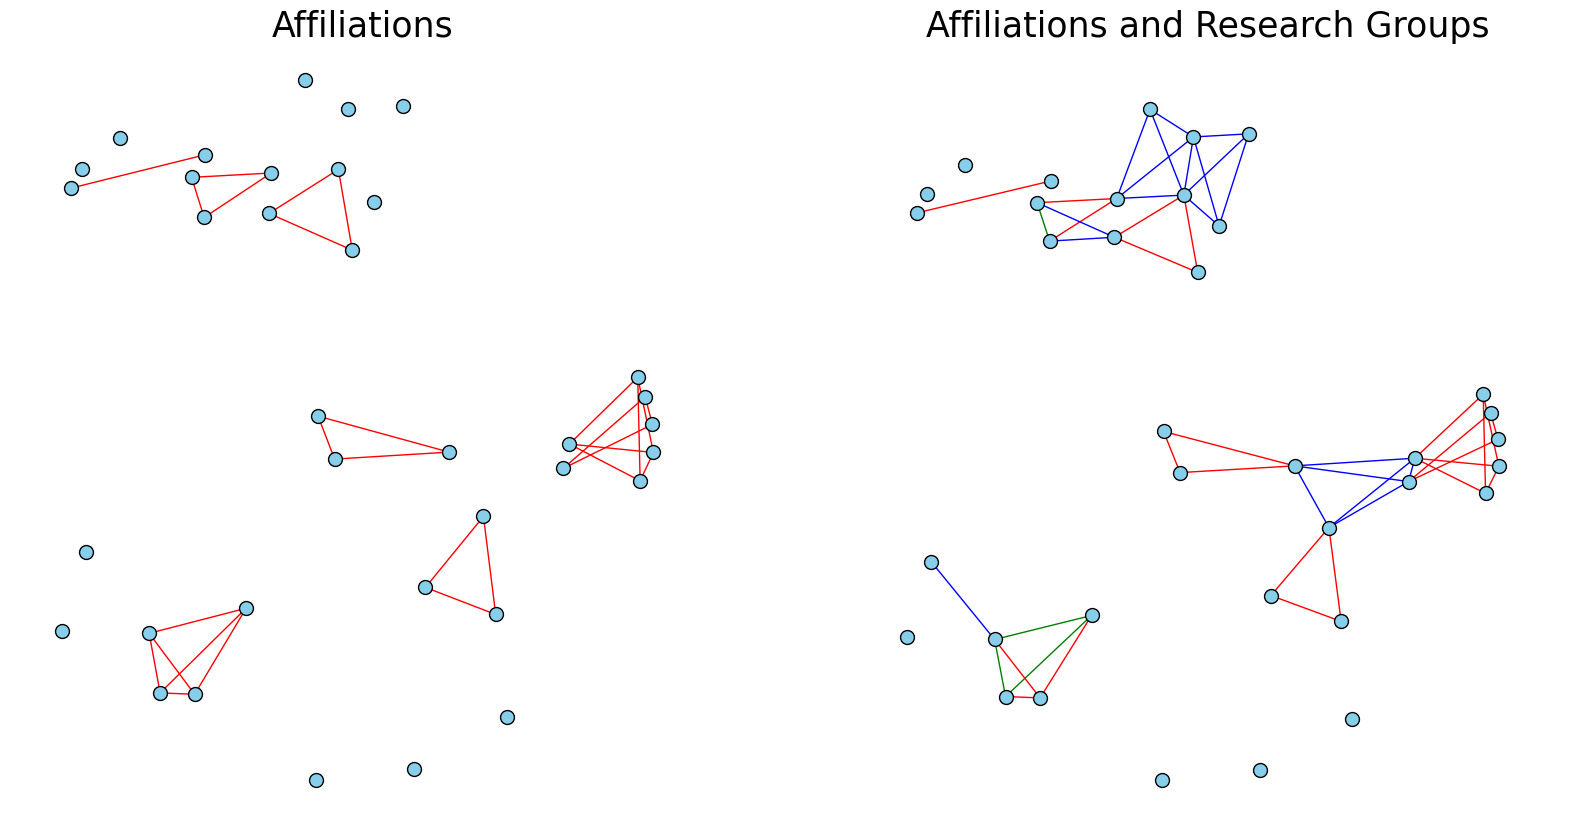

In [53]:
# Create network  plot
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 2: Edges colored based on their attributes using a colormap
G2 = nx.Graph()
G2.add_nodes_from([node['id'] for node in node_list])
for _, row in edge_df_new.iterrows():
    G2.add_edge(row['source'], row['target'], edge_attribute=row['edge_attribute'])

# Use the Fruchterman-Reingold layout for positioning nodes
pos = nx.fruchterman_reingold_layout(G2, k=4, iterations=500, scale=1.5, seed=6)

# Create a colormap based on edge attributes
edge_colors2 = []
edge_color_map = {'affiliation': 'red', 'private': 'blue', 'both': 'green'}
for edge in G2.edges():
    edge_attribute = G2[edge[0]][edge[1]]['edge_attribute']
    edge_colors2.append(edge_color_map[edge_attribute])

# Draw the network
nx.draw(G2, pos, with_labels=False, node_size=100, node_color='skyblue', edgecolors='black', font_size=8, edge_color=edge_colors2, ax=axes[1])
axes[1].set_title('Affiliations and Research Groups', fontsize=25)

# Plot 1: Only "affiliation" and "both" edges, all in red
G1 = nx.Graph()
G1.add_nodes_from([node['id'] for node in node_list])
edges1 = [(row['source'], row['target']) for _, row in edge_df_new.iterrows() if row['edge_attribute'] in ['affiliation', 'both']]
G1.add_edges_from(edges1)

# Use the same layout positions as G2
pos = nx.fruchterman_reingold_layout(G1, pos=pos, fixed=pos.keys(), seed=6)

# Draw Graph 1 with red edges
nx.draw(G1, pos, with_labels=False, node_size=100, node_color='skyblue', edgecolors='black', font_size=8, edge_color='red', ax=axes[0])
axes[0].set_title('Affiliations', fontsize=25)

# Save the plot as a PNG file
plt.savefig('plots-and-tables/network.png')


### Network Simulation 

In [54]:
# Define the parameters
n = 100  # Number of nodes
p = 0.05  # Probability of edge creation
num_networks = 3
num_network_permutations = 50  # Number of network permutations 
edge_share_values = [0, 0.1, 0.25, 0.5, 0.7, 0.8, 0.9, 1] # Define the share of edges to remove

# Create the original ER network with the specified seed
er_networks = [nx.erdos_renyi_graph(n, p, seed=i) for i in range(num_networks)]

In [55]:
all_modified_networks = {}

# Iterate over each original network
for idx, er_network in enumerate(er_networks):
    # Initialize the dictionary to store modified networks for the current original network
    modified_networks = {}
    
    # Iterate over each edge share value
    for edge_share in edge_share_values:
        # Initialize a list to store modified networks for the current edge share
        modified_networks[edge_share] = []
        
        # Iterate for each network
        for i in range(1, num_network_permutations + 1):
            # Create a copy of the original network
            network_copy = er_network.copy()

            # Randomly choose edges to remove based on the current edge share
            edges_to_remove = random.sample(list(network_copy.edges()), int(edge_share * network_copy.number_of_edges()))

            # Remove the chosen edges from the graph
            network_copy.remove_edges_from(edges_to_remove)
            
            # Append the modified network to the list for the current edge share
            modified_networks[edge_share].append(network_copy)
    
    # Store the modified networks dictionary in the main dictionary
    all_modified_networks[f'network_{idx+1}'] = modified_networks

In [56]:
# Define a function to get the first-order connections of a node
def get_first_order_connections(graph, node):
    neighbors = set(graph.neighbors(node))
    neighbors.add(node)  # Add the node itself to its group
    return neighbors

In [57]:
all_groups = {}

# Iterate over each original network's modified networks
for network_key, modified_networks in all_modified_networks.items():
    all_groups[network_key] = {}
    
    # Loop through the modified networks and create groups
    for edge_share, networks in modified_networks.items():
        all_groups[network_key][edge_share] = {}  # Initialize a dictionary for this edge share value
        
        for idx, net in enumerate(networks):
            # Create groups based on first-order connections
            groups = {}
            for node in net.nodes:
                groups[node] = list(get_first_order_connections(net, node))

            # Store the groups in the dictionary for this network
            group_dict = {f"Group {node} {network_key}": group for node, group in groups.items()}
            all_groups[network_key][edge_share][f"G{idx+1}"] = group_dict

In [58]:
# Generate lists of networks to combine
list_networks_to_combine = []
for i in range(2, num_networks + 1):
    list_networks_to_combine.append([f'network_{j}' for j in range(1, i + 1)])

# Print the generated list
print(list_networks_to_combine)

[['network_1', 'network_2'], ['network_1', 'network_2', 'network_3']]


In [59]:
# Initialize a new dictionary to store the combined groupings
all_combined_groups = {}

# Iterate over each list of networks to combine
for networks_to_combine in list_networks_to_combine:
    # Initialize a dictionary to store the combined groupings for this combination
    combined_groups = {}
    
    # Iterate over each edge share value
    for edge_share, edge_share_data in all_groups[networks_to_combine[0]].items():  # Assuming all networks have the same edge share values
        combined_groups[edge_share] = {}
        
        # Combine groupings from all specified networks for the current edge share value and each Gi
        for Gi in edge_share_data.keys():
            combined_groups[edge_share][Gi] = {}
            for network_key in networks_to_combine:
                if edge_share in all_groups[network_key]:
                    network_data = all_groups[network_key][edge_share]
                    if Gi in network_data:
                        groups = network_data[Gi]
                        for group_name, nodes in groups.items():
                            if group_name not in combined_groups[edge_share][Gi]:
                                combined_groups[edge_share][Gi][group_name] = nodes
                            else:
                                combined_groups[edge_share][Gi][group_name].extend(nodes)
                                combined_groups[edge_share][Gi][group_name] = list(set(combined_groups[edge_share][Gi][group_name]))
    
    # Store the combined groupings for this combination in the overall dictionary
    all_combined_groups[str(networks_to_combine)] = combined_groups


In [61]:
node_values = {node: 10 for node in er_network.nodes}

In [62]:
# Assuming you have the function `analysis_functions.connection_oriented_cluster_match`
# and the `node_values` dictionary defined

# Initialize an empty dictionary to store the results
results = {}

# Loop through all networks in all_groups
for network_key, edge_share_groups in all_combined_groups.items():
    print(network_key)
    # Initialize a dictionary for each network
    results[network_key] = {}

    # Loop through all edge share values for the current network
    for edge_share, network_groups in edge_share_groups.items():
        # Initialize a dictionary for each edge share value
        results[network_key][edge_share] = {}
        
        # Loop through all networks for the current edge share value
        for network_name, groups in network_groups.items():
            # Calculate the score for the current network
            score = analysis_functions.connection_oriented_cluster_match(groups, node_values)
            
            # Store the score in the results dictionary
            results[network_key][edge_share][network_name] = score


['network_1', 'network_2']
['network_1', 'network_2', 'network_3']


In [63]:
# Initialize an empty dictionary to store the results
base_network_results = {}

# Access 'network_1' directly
network_key = 'network_1'

# Loop through all edge share values for 'network_1'
for edge_share, network_groups in all_groups[network_key].items():
    # Initialize a dictionary for each edge share value
    base_network_results[edge_share] = {}
    
    # Loop through all groups for the current edge share value
    for group_name, groups in network_groups.items():
        # Calculate the score for the current group
        score = analysis_functions.connection_oriented_cluster_match(groups, node_values)
        
        # Store the score in the results dictionary
        base_network_results[edge_share][group_name] = score


In [64]:
# Calculate plurality and quadratic score of the original network 

# generate groups 
original_groups = {}
for node in er_networks[0].nodes:
    original_groups[node] = list(get_first_order_connections(er_networks[0], node))

plurality_score = analysis_functions.connection_oriented_cluster_match(original_groups, node_values)
quadratic_score = sum(math.sqrt(value) for value in node_values.values())

plurality_score, quadratic_score

(207.58380564804568, 316.2277660168381)

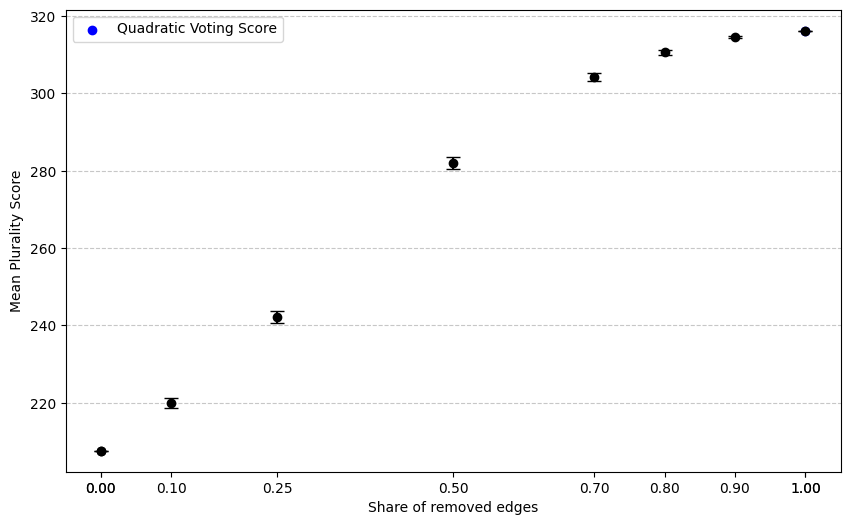

In [65]:
# Calculate mean plurality scores and standard deviations for each share
mean_scores = []
std_devs = []

for edge_share, scores in base_network_results.items():
    mean_score = np.mean(list(scores.values()))
    std_dev = np.std(list(scores.values()))
    mean_scores.append(mean_score)
    std_devs.append(std_dev)

# Plot the mean plurality scores as dots with error bars indicating the standard deviations
plt.figure(figsize=(10, 6))
plt.errorbar(edge_share_values, mean_scores, yerr=std_devs, fmt='o', capsize=5, color='black')

# Include plurality and quadratic score at the extremes
plt.scatter(0, plurality_score, color='black')
plt.scatter(1, quadratic_score, color='blue', label='Quadratic Voting Score')

# Add 0 and 1 to the x-axis ticks
all_edge_share_values = [0] + edge_share_values + [1]

# Label the plot
plt.xlabel('Share of removed edges')
plt.ylabel('Mean Plurality Score')
plt.xticks(all_edge_share_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Save the plot
plt.savefig('plots-and-tables/scores.png')


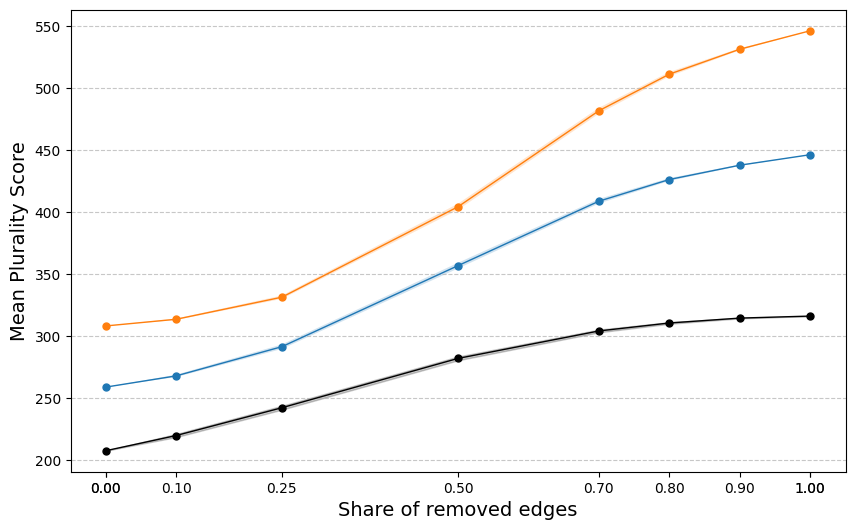

In [74]:
# Calculate mean plurality scores and standard deviations for each share in base_network_results
mean_scores = []
std_devs = []

for edge_share, scores in base_network_results.items():
    mean_score = np.mean(list(scores.values()))
    std_dev = np.std(list(scores.values()))
    mean_scores.append(mean_score)
    std_devs.append(std_dev)

# Plot the mean plurality scores with error bands indicating the standard deviations
plt.figure(figsize=(10, 6))

# Plot mean scores
plt.plot(edge_share_values, mean_scores, '-o', color='black', label='Mean Plurality Score',
         markersize=5, linewidth=1)  # Smaller line and dot size

# Plot error bands
plt.fill_between(edge_share_values, 
                 np.array(mean_scores) - np.array(std_devs), 
                 np.array(mean_scores) + np.array(std_devs), 
                 color='black', alpha=0.2)

# Add 0 and 1 to the x-axis ticks
all_edge_share_values = [0] + edge_share_values + [1]
plt.xticks(all_edge_share_values)

# Label the plot
plt.xlabel('Share of removed edges', fontsize=14)  # Increase font size of x-axis label
plt.ylabel('Mean Plurality Score', fontsize=14)  # Increase font size of y-axis label
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot additional lines with error bands for each key in results
for key, data in results.items():
    key_mean_scores = []
    key_std_devs = []
    for edge_share, scores in data.items():
        mean_score = np.mean(list(scores.values()))
        std_dev = np.std(list(scores.values()))
        key_mean_scores.append(mean_score)
        key_std_devs.append(std_dev)
    
    # Plot mean scores for each key
    plt.plot(edge_share_values, key_mean_scores, '-o', label=key, markersize=5, linewidth=1)  # Smaller line and dot size
    
    # Plot error bands for each key
    plt.fill_between(edge_share_values, 
                     np.array(key_mean_scores) - np.array(key_std_devs), 
                     np.array(key_mean_scores) + np.array(key_std_devs), 
                     alpha=0.2)

# Save the plot
plt.savefig('plots-and-tables/scores.png')

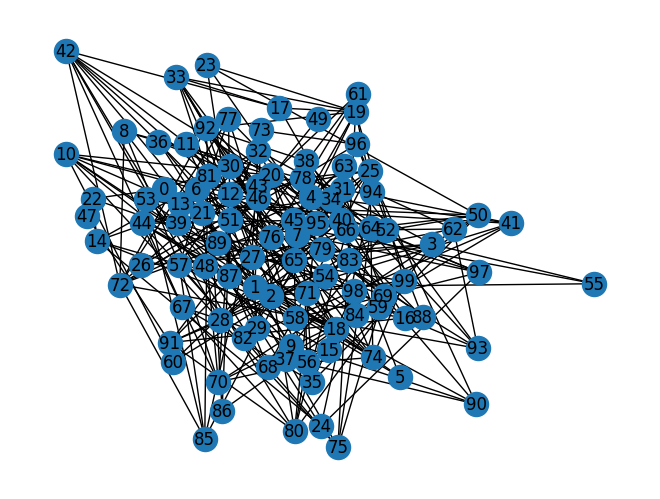

In [67]:
test_network = nx.erdos_renyi_graph(100, 0.05, seed=1)

# Generate positions for the nodes (fixing the positions)
pos = nx.spring_layout(test_network, seed=1)
# Draw the modified network with fixed node positions
nx.draw(er_network, pos=pos, with_labels=True)

In [68]:
exp_num_edges = (p*(n*(n-1)))/2
exp_num_edges

247.5